In [1]:
import yfinance as yf
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from openai import OpenAI
from dotenv import load_dotenv

from utils import get_factors, get_monthly_returns, get_stock_details, get_portfolio_weights, select_factor_list, visualize_returns
from helpers import run_regression, compute_annual_return, get_insights, forecast_factors, compute_monthly_expected_returns

load_dotenv()

True

We want to explain our portfolio, or single stock, using factors defined by the a series of linear models that relates the expected return of a stock to several historical factors of the market. The most simple of these is the CAPM model, which aims to relate the expected return of an asset to the the expected return of the market. The model is defined as follows:

$$
E[R_i] = R_f + \beta_i (E[R_m] - R_f)
$$

Where:
- $E[R_i]$ is the expected return of the stock
- $R_f$ is the risk-free rate
- $\beta_i$ is the beta of the stock
- $E[R_m]$ is the expected return of the market

The beta of a stock is a measure of the stock's volatility in relation to the market. A beta of 1 means that the stock moves in line with the market. A beta greater than 1 means that the stock is more volatile than the market, and a beta less than 1 means that the stock is less volatile than the market.

In our case, we will grab the market excess returns from the Kenneth French data library.

This same model is used extended by the Fama-French 3 factor model, which adds two more factors to the model. The Fama-French model is defined as follows:

$$
E[R_i] = R_f + \beta_i (E[R_m] - R_f) + s_i SMB + h_i HML
$$

Where:
- $s_i$ is the stock's exposure to the size factor
- $SMB$ is the size factor
- $h_i$ is the stock's exposure to the value factor
- $HML$ is the value factor

This model can be extended further to the Fama-French 5 factor model, which adds two more factors to the model. The Fama-French 5 factor model is defined as follows:

$$
E[R_i] = R_f + \beta_i (E[R_m] - R_f) + s_i SMB + h_i HML + r_i RMW + c_i CMA
$$

Where:
- $r_i$ is the stock's exposure to the profitability factor
- $RMW$ is the profitability factor
- $c_i$ is the stock's exposure to the investment factor
- $CMA$ is the investment factor

[*********************100%%**********************]  1 of 1 completed


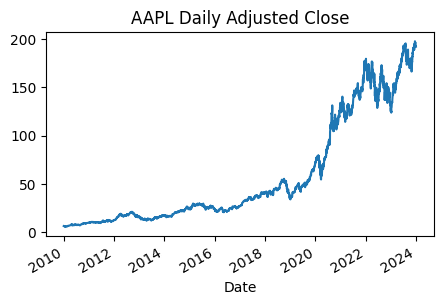

,Adj Close,Return
Date,,
2010-02,6.178449,6.539654
2010-03,7.095765,14.847035
2010-04,7.883543,11.102079
2010-05,7.756429,-1.612395
2010-06,7.594884,-2.082721
...,...,...
2023-08,187.129898,-4.238383
2023-09,170.535522,-8.867838
2023-10,170.097260,-0.256992


In [2]:
# As an example, we will use the stock of Apple Inc. (AAPL)
returns = yf.download("AAPL", start="2010-01-01", end="2023-12-31")
returns["Adj Close"].plot(title="AAPL Daily Adjusted Close", figsize=(5, 3))
plt.show()

# calculate daily returns of QQQ
# data = returns["Adj Close"].to_frame()
# data["Return"] = data["Adj Close"].pct_change() * 100
# data.dropna(inplace=True)
# data

data = returns["Adj Close"].resample("ME").ffill().to_frame()
data.index = data.index.to_period("M")
data["Return"] = data["Adj Close"].pct_change() * 100
data.dropna(inplace=True)
data

In [3]:
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "TSLA", "NVDA", "PYPL", "ADBE", "NFLX"]
# weights = [0.1 for _ in range(len(tickers))] # TODO: change weights
initial_amount = 10000
start_date = "2010-01-01"
end_date = "2023-12-31"
weights = get_portfolio_weights(tickers, strategy="ewp", initial_amount=initial_amount, start_date=start_date, end_date=end_date)
model_type = "capm" # Either capm, ff3, or ff5
factor_list = select_factor_list(model_type)

# print(portfolio.columns)
print(len(tickers), len(weights))
if len(tickers) != len(weights):
    raise ValueError("Number of tickers and weights must be equal")

[*********************100%%**********************]  10 of 10 completed


Ticker          AAPL      ADBE      AMZN     GOOGL      META      MSFT  \
Date                                                                     
2015-07-07 -0.002460  0.001118  0.001560  0.008083 -0.003769 -0.002028   
2015-07-08 -0.024823 -0.007445 -0.016074 -0.015145 -0.018000 -0.001354   
2015-07-09 -0.020396  0.006001  0.010915  0.005446  0.002685  0.006329   
2015-07-10  0.026734  0.001491  0.020995  0.021041  0.024103  0.002021   
2015-07-13  0.019306  0.010547  0.027192  0.028088  0.024446  0.020847   
...              ...       ...       ...       ...       ...       ...   
2023-12-22 -0.005547 -0.002316 -0.002730  0.007620 -0.001977  0.002784   
2023-12-26 -0.002841 -0.000818 -0.000065  0.000212  0.004075  0.000214   
2023-12-27  0.000518 -0.003644 -0.000456 -0.008126  0.008455 -0.001575   
2023-12-28  0.002226 -0.000939  0.000261 -0.000997  0.001369  0.003235   
2023-12-29 -0.005424  0.001813 -0.009388 -0.003851 -0.012168  0.002025   

Ticker          NFLX      NVDA      P

BdbQuit: 

In [35]:
# We will also take the data of a portfolio with weights
portfolio = get_monthly_returns(tickers, start_date, end_date)
factors_monthly = get_factors()
portfolio_return = (portfolio * weights).sum(axis=1)

factors_subset = factors_monthly[factors_monthly.index.isin(data.index)].copy()
factors_subset["Excess Returns"] = portfolio_return - factors_subset["RF"]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>], dtype=object)

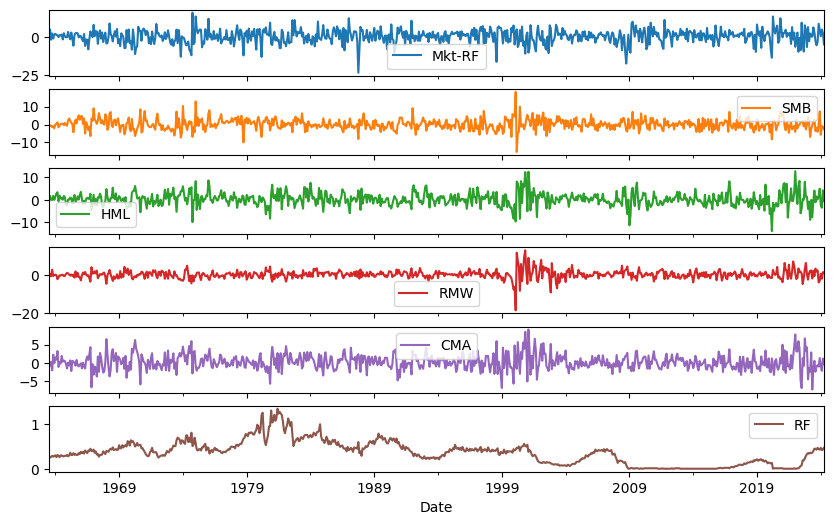

In [39]:
# Plot factors across time
factors_monthly.plot(subplots=True, figsize=(10, 6))

<Axes: title={'center': 'Portfolio Monthly Returns'}, xlabel='Date'>

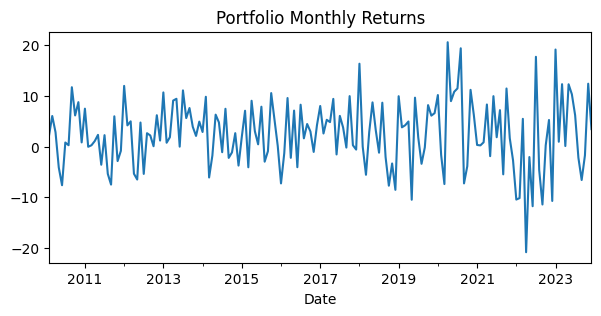

In [41]:
# Plot portfolio returns
portfolio_return.plot(title="Portfolio Monthly Returns", figsize=(7, 3))

In [42]:
# X = sm.add_constant(factors_subset[["Mkt-RF"]]) # CAPM model
# X = sm.add_constant(factors_subset[["Mkt-RF", "SMB", "HML"]]) # Fama-French 3-factor model
# X = sm.add_constant(factors_subset[["Mkt-RF", "SMB", "HML", "RMW", "CMA"]]) # Fama-French 5-factor model
# y = factors_subset["Excess Returns"]
# model = sm.OLS(y, X).fit()
# model.summary()
model = run_regression(factors_subset, factor_list)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Excess Returns   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     244.9
Date:                Tue, 30 Jul 2024   Prob (F-statistic):           1.98e-34
Time:                        21:22:27   Log-Likelihood:                -477.04
No. Observations:                 167   AIC:                             958.1
Df Residuals:                     165   BIC:                             964.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1808      0.337      3.500      0.001       0.515       1.847
Mkt-RF         1.1572      0.074     15.650      0.000       1.011       1.303
==============================================================================
Omnibus:                        0.086   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.958   Jarque-Bera (JB):                0.225
Skew:                           0.024   Prob(JB):                        0.894
Kurtosis:                       2.827   Cond. No.                         4.71
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now that we have built our regression model, we can visualize how each coefficient affects the expected return of the stock.

/opt/homebrew/Caskroom/miniconda/base/envs/quant/lib/python3.9/site-packages/matplotlib/cbook.py:1762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


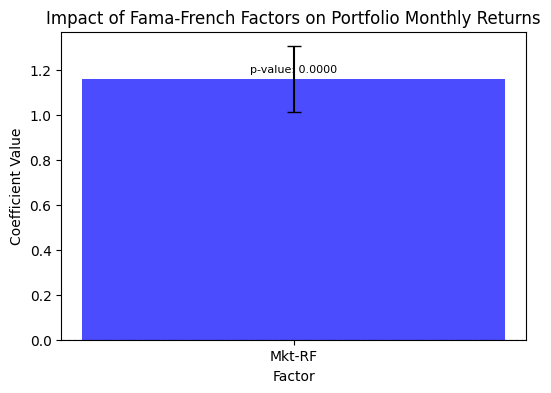

In [43]:
# Extract the coefficients and confidence intervals
factors = model.params.index[1:]  # ['Mkt_Rf', 'SMB', 'HML']
coefficients = model.params.values[1:]
confidence_intervals = model.conf_int().iloc[1:]

ols_data = pd.DataFrame({
    "Factor": factors,
    "Coefficient": coefficients,
    "Confidence_Lower": confidence_intervals[0],
    "Confidence_Upper": confidence_intervals[1],
    "P-Value": model.pvalues[1:]
})

# Plotting for visual confirmation
plt.figure(figsize=(6, 4))

bars = plt.bar(ols_data["Factor"], ols_data["Coefficient"], color='blue', alpha=0.7, capsize=10)
plt.errorbar(
    ols_data["Factor"],
    ols_data["Coefficient"],
    yerr=[
        ols_data["Coefficient"] - ols_data["Confidence_Lower"],
        ols_data["Confidence_Upper"] - ols_data["Coefficient"]
    ],
    fmt='none',
    capsize=5,
    color='black'
)

# Add the p-value for each factor to the plot
for i, row in ols_data.iterrows():
    plt.text(
        i,
        row['Coefficient'] + 0.02,  # Position text slightly above the bar
        f"p-value: {row['P-Value']:.4f}",
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.title("Impact of Fama-French Factors on Portfolio Monthly Returns")
plt.xlabel("Factor")
plt.ylabel("Coefficient Value")
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.show()

In [11]:
client = OpenAI()

# Analyze the OLS regression results using GPT-4
stock_details = get_stock_details(tickers)
insights = get_insights(client, ols_data, portfolio=portfolio_return, stock_details=stock_details, advanced=False)
print("Insights from GPT-4o:\n", insights)

Insights from GPT-4o:
 The regression results you have provided illustrate how various factors impact returns on a portfolio consisting of four stocks: Apple Inc. (AAPL), Amazon.com, Inc. (AMZN), Alphabet Inc. (GOOGL), and Microsoft Corporation (MSFT). Let’s break down the insights from the regression coefficients and how they affect the individual tickers in the context of the entire portfolio.

### Understanding the Factors
1. **Mkt-RF (Market Return minus Risk-Free Rate)**: The coefficient of **1.139** indicates that for every 1% increase in the market return, the portfolio's expected return increases by approximately 1.14%. This strong positive correlation suggests a heavy reliance on market movements.
  
2. **SMB (Small Minus Big)**: With a coefficient of **-0.502**, this indicates the portfolio tends to underperform as the market shifts towards small-cap companies. This suggests that AAPL, AMZN, GOOGL, and MSFT are either large-cap companies or are less aligned with small-cap gro

In [45]:
# Example usage
forecasted_factors = forecast_factors(factors_monthly, model_type=model_type, steps=12)
monthly_expected_returns = compute_monthly_expected_returns(model, forecasted_factors)
annual_expected_return = compute_annual_return(monthly_expected_returns)

print(monthly_expected_returns)
print("Expected Annual Return for the Next 12 Months: {:.2f}%".format(annual_expected_return * 100))


[-4.229616317755325, 5.546431475044065, 5.906832699655654, 4.24116354997763, 0.6198357293727239, 4.771952124412135, -3.733644849870652, 2.283726763233537, 1.8802180765727594, 1.041264757861085, -2.632942945240579, 3.3610488486586085]
Expected Annual Return for the Next 12 Months: 20.01%


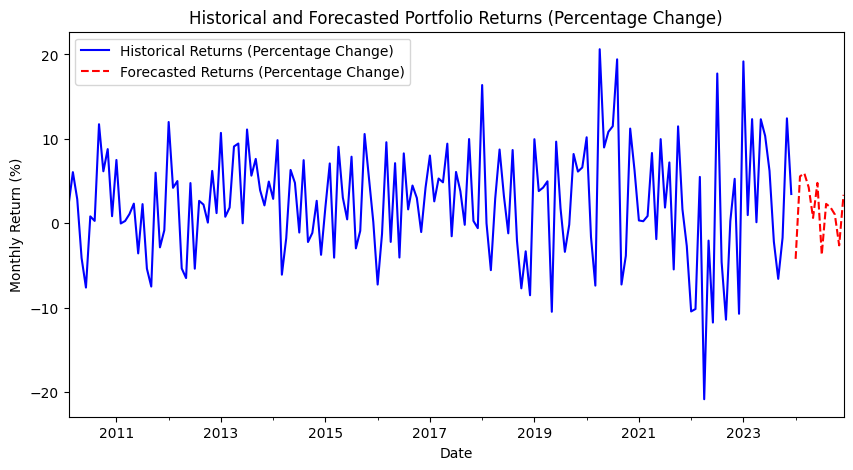

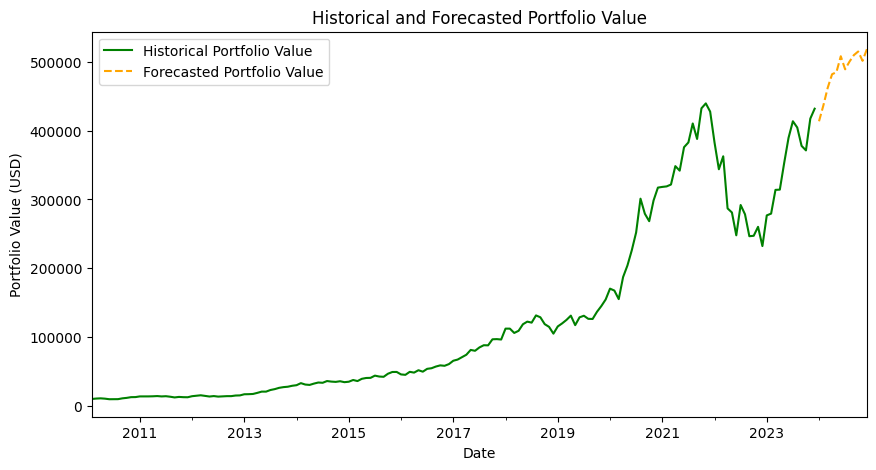

In [46]:
portfolio_return = (portfolio * weights).sum(axis=1)
# print(portfolio, weights)
visualize_returns(portfolio_return, monthly_expected_returns, initial_amount)